# One class vs others

Here we train a model to classify a class vs others. The sample are from the following:

+ All samples from the desired class. Let N denote the number of these samples.
+ At most N samples from other classes
+ N samples from the normal samples (those samples which do not belong to any of the six classes).


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Train data

In [43]:
des_class='obscene'#desired class

df=pd.read_csv('/home/arash/MEGA/MEGAsync/Machine Learning/Kaggle/Toxic/Data/train.csv')
class_names=df.columns[2:].tolist()
des_idx = class_names.index(des_class)#index of the desired class
n_classes = np.sum(df[class_names].values,axis=0)
n_des_class=n_classes[des_idx]
labels_sum=np.sum(df[class_names].values,axis=1)

df_des_class = df[df[des_class]==1]#all samples from the desired class
df_other_classes = df[(df[des_class]==0) & (labels_sum!=0)]#samples from other classes
if n_des_class<df_other_classes.shape[0]:
    df_other_classes=df_other_classes.sample(n_des_class)
df_normal=df.iloc[labels_sum==0,:].sample(n_des_class)#samples from normal texts

texts = df_des_class.comment_text.tolist()+ df_other_classes.comment_text.tolist()+\
        df_normal.comment_text.tolist()
labels = np.hstack((df_des_class[des_class].values,
                    df_other_classes[des_class].values,
                   df_normal[des_class].values))

texts , labels = shuffle(texts,labels,random_state=0)

print('Total number of samples: %d '%len(texts))
print('there are %d postive samples'%df_des_class.shape[0])

Total number of samples: 24674 
there are 8449 postive samples


# Feature extraction

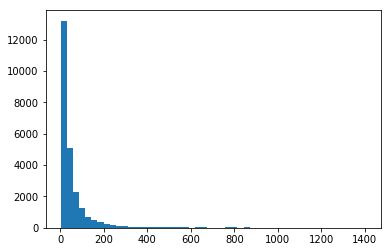

In [44]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
T = Tokenizer()
T.fit_on_texts(texts)
sequences=T.texts_to_sequences(texts)
seq_len = map(lambda x:len(x),sequences)
_=plt.hist(seq_len,50)
MAX_SEQ_LEN = 200
X = pad_sequences(sequences=sequences,maxlen=MAX_SEQ_LEN,padding='pre')
DICT_SIZE=np.max(X)+1

# Model

In [50]:
from keras.models import Model
from keras.layers import Input,Conv1D,Dense,Embedding,Flatten,concatenate,MaxPool1D,Dropout

d_r=.8#dropout rate

inputs = Input(shape=(MAX_SEQ_LEN,))
embed1 = Embedding(input_dim=DICT_SIZE,output_dim=50,input_length=MAX_SEQ_LEN)(inputs)

n_featMap=10
conv1_k3 = Conv1D(filters=n_featMap,kernel_size=3,strides=1,activation='relu')(embed1)
pool1_k3 = MaxPool1D(pool_size=int(conv1_k3.get_shape()[1]))(conv1_k3)#max pool over all words
conv1_k4 = Conv1D(filters=n_featMap,kernel_size=4,strides=1,activation='relu')(embed1)
pool1_k4 = MaxPool1D(pool_size=int(conv1_k4.get_shape()[1]))(conv1_k4)#max pool over all words
conv1_k5 = Conv1D(filters=n_featMap,kernel_size=5,strides=1,activation='relu')(embed1)
pool1_k5 = MaxPool1D(pool_size=int(conv1_k5.get_shape()[1]))(conv1_k5)#max pool over all words

features1 = Flatten()(concatenate([pool1_k3,pool1_k4,pool1_k5]))
dense1 = Dropout(d_r)(Dense(100,activation='sigmoid')(features1))
dense2 = Dropout(d_r)(Dense(50,activation='sigmoid')(dense1))
out = Dense(1,activation='sigmoid')(dense2)

model = Model(inputs=inputs,outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 200, 50)      2833500     input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 198, 10)      1510        embedding_22[0][0]               
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 197, 10)      2010        embedding_22[0][0]               
__________________________________________________________________________________________________
conv1d_39 

In [51]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x=X,y=labels,validation_split=.1,batch_size=50,epochs=100,verbose=1)

Train on 22206 samples, validate on 2468 samples
Epoch 1/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.6967 - acc: 0.6165 - val_loss: 0.6397 - val_acc: 0.6499
Epoch 2/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.6183 - acc: 0.6737 - val_loss: 0.4913 - val_acc: 0.7954
Epoch 3/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.4053 - acc: 0.8424 - val_loss: 0.2867 - val_acc: 0.8910
Epoch 4/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.3337 - acc: 0.8810 - val_loss: 0.2707 - val_acc: 0.8947
Epoch 5/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.3079 - acc: 0.8895 - val_loss: 0.2714 - val_acc: 0.8938
Epoch 6/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.2902 - acc: 0.8967 - val_loss: 0.2787 - val_acc: 0.8979
Epoch 7/100
22206/22206 [==============================] - 27s 1ms/step - loss: 0.2777 - acc: 0.9016 - val_loss: 0.2782 - v

 3900/22206 [====>.........................] - ETA: 21s - loss: 0.0144 - acc: 0.9964

KeyboardInterrupt: 

# Logistic regression model

In [49]:
inputs = Input(shape=(MAX_SEQ_LEN,))
embed1 = Embedding(input_dim=DICT_SIZE,output_dim=50,input_length=MAX_SEQ_LEN)(inputs)
features = Flatten()(embed1)
out = Dense(1,activation='sigmoid')(features)
model = Model(inputs=inputs,outputs=out)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x=X,y=labels,validation_split=.1,batch_size=50,epochs=10,verbose=1)

Train on 22206 samples, validate on 2468 samples
Epoch 1/10
22206/22206 [==============================] - 14s 613us/step - loss: 0.4952 - acc: 0.7677 - val_loss: 0.3863 - val_acc: 0.8420
Epoch 2/10
22206/22206 [==============================] - 13s 589us/step - loss: 0.3299 - acc: 0.8667 - val_loss: 0.3683 - val_acc: 0.8643
Epoch 3/10
22206/22206 [==============================] - 13s 590us/step - loss: 0.2833 - acc: 0.8869 - val_loss: 0.3772 - val_acc: 0.8570
Epoch 4/10
22206/22206 [==============================] - 13s 590us/step - loss: 0.2472 - acc: 0.9040 - val_loss: 0.3961 - val_acc: 0.8456
Epoch 5/10
22206/22206 [==============================] - 13s 591us/step - loss: 0.2135 - acc: 0.9193 - val_loss: 0.5418 - val_acc: 0.7755
Epoch 6/10
14250/22206 [==================>...........] - ETA: 4s - loss: 0.1824 - acc: 0.9321

KeyboardInterrupt: 

So the accuracy of this model for 'toxic' is about 88%.

In [42]:
class_names

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']